Assignment 2\
Name: Tong Wai Ho\
Sid: 54812369

Question 1 - LLM for Data Engineering

In [1]:
#a

I want to train a recommender system. Generate a synthetic dataset for training a recommender system and visualize it.

Question 2 - Data Indexing

a)\
p = 3

b)\
Yes, for p =3, we can have at most 2 keys and 3 children.\
\
Step 1: Insert 21,34\
\
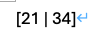\
\
Step 2: Insert 41\
\
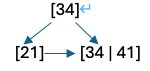\
\
Step 3: Insert 51\
\
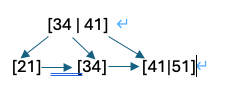\
\
Step 4: Insert 53\
\
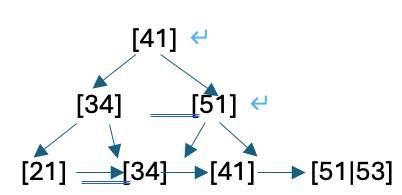\
\
Step 5: Insert 77, 83, 85\
\
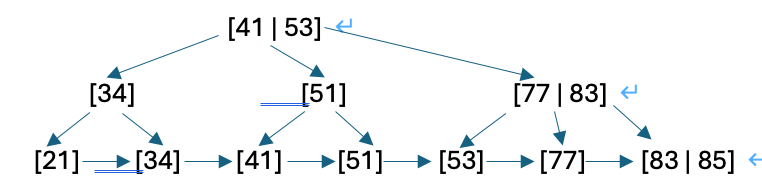\
\
Step 6: Insert 86\
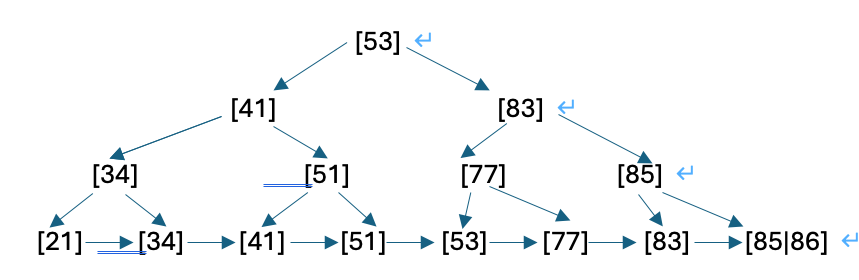

c)\
Insert 32\
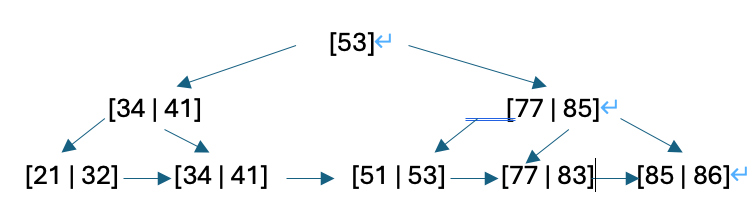\
\
Insert 84\
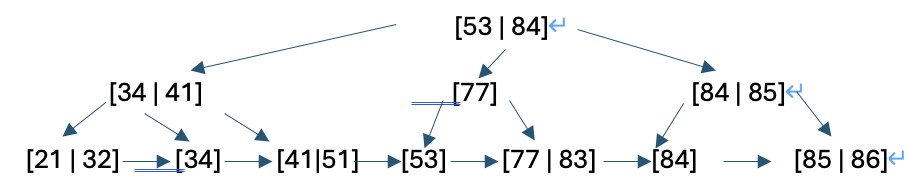\
\
Insert 19\
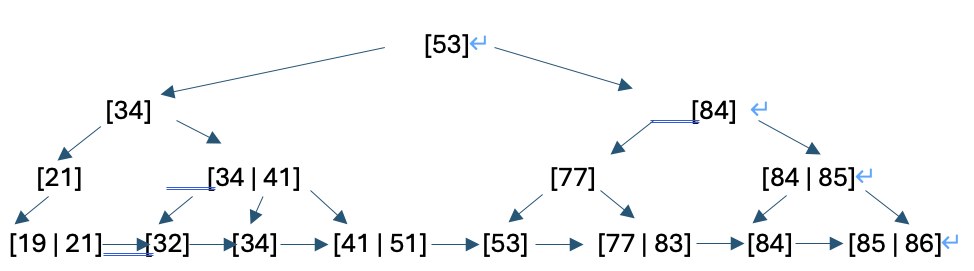

d)\
Delete element as follow {21, 34, 41, 51, 53}\
\
Delete 21\
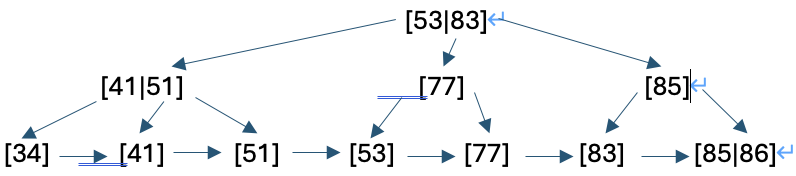\
\
Delete 34\
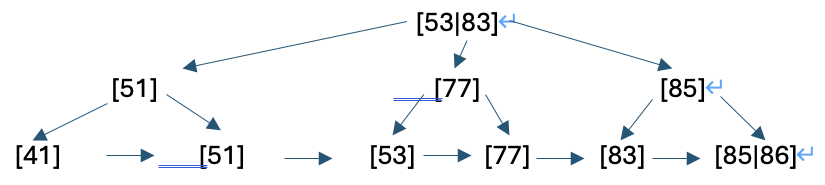\
\
Delete 41\
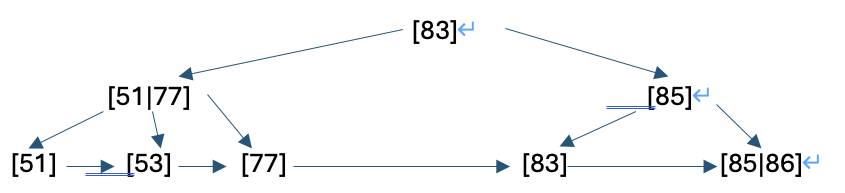\
\
Delete 51\
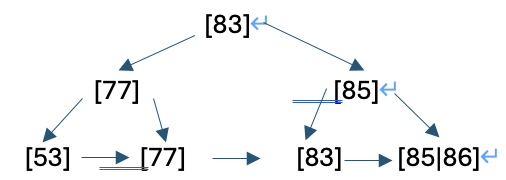\
\
Delete 53\
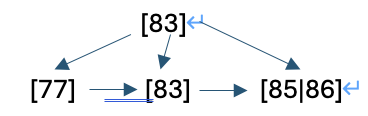

Question 3 - Data Querying